# Import libraries

In [5]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [6]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math  
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential 
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns 
import yfinance as yf

print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.9.2
Num GPUs: 1


In [7]:
np.random.seed(42)
tf.random.set_seed(42)

# Preprocessing

In [1]:
def load(symbol,start_date,end_date):
  df = yf.download(symbol, start=start_date, end=end_date)
  return df

In [2]:
def count(start_date,end_date):
  end_date_object = datetime.strptime(end_date, '%Y-%m-%d').date()
  start_date_object = datetime.strptime(start_date, '%Y-%m-%d').date()
  return (end_date_object-start_date_object)

In [3]:
def plot(df):
  df_plot = df.copy()

  num_cols = 2
  num_rows = int(round(df_plot.shape[1] / num_cols, 0))

  fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(20, 10))
  for i, ax in enumerate(fig.axes):
          sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
          ax.tick_params(axis="x", rotation=30, labelsize=15, length=0)
          ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

In [4]:
def preprocess(df, seq_len, split=0.8):
  sequence_length = seq_len
  
  stock_features = ['High', 'Low', 'Open', 'Close', 'Volume']

  train_df = df.sort_values(by=['Date']).copy()

  data = pd.DataFrame(train_df)
  data_filtered = data[stock_features]

  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']
  nrows = data_filtered.shape[0]
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)

  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)


  index_Close = data.columns.get_loc("Close")

 
  train_data_len = math.ceil(np_data_scaled.shape[0] *split)

  train_data = np_data_scaled[0:train_data_len, :]
  val_data = np_data_scaled[train_data_len - sequence_length:, :]


  def partition_rnn(sequence_length, data):
      x, y = [], []
      data_len = data.shape[0]
      for i in range(sequence_length, data_len):
          x.append(data[i-sequence_length:i,:]) 
          y.append(data[i, index_Close]) 
      
      x = np.array(x)
      y = np.array(y)
      return x, y

  x_train, y_train = partition_rnn(sequence_length, train_data)
  x_val, y_val = partition_rnn(sequence_length, val_data)

  return stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val


# Build RNN model

In [8]:
def create_RNN(hidden_units, input_shape, rnn_type, lr, loss, drop=0.2):
  model = Sequential()
  if rnn_type == 'RNN':

    model.add(SimpleRNN(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(0.2))
    model.add(SimpleRNN(hidden_units, return_sequences=True))
    model.add(SimpleRNN(hidden_units, return_sequences=False))

  elif rnn_type == 'LSTM':

    model.add(LSTM(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, return_sequences=True))
    model.add(LSTM(hidden_units, return_sequences=False))

  elif rnn_type == 'GRU':

    model.add(GRU(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(0.2))
    model.add(GRU(hidden_units, return_sequences=True))
    model.add(GRU(hidden_units, return_sequences=False))

  model.add(Dense(1))

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=loss)

  return model

In [9]:
def loss_plot(history, epochs, rnn_type ="Vanilla RNN"):
  fig, ax = plt.subplots(figsize=(12, 5), sharex=True)
  sns.lineplot(data=history.history["loss"])
  sns.lineplot(data=history.history["val_loss"])
  plt.title(f"Loss Curve w/ {rnn_type}")
  plt.ylabel("Loss")
  plt.xlabel("Steps")
  plt.legend(["Train", "Val"], loc="upper left")
  plt.grid()
  plt.show()

In [10]:
def evaluate(model, x_train, y_train, x_val, y_val, scaler_pred, epoch, batch_size): #SimpleRNN_model | LSTM_model | GRU_model
  epochs = epoch
  batch_size = batch_size
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(x_val, y_val)
                      #callbacks=[early_stop])
                    )
                      
                      


  y_pred_scaled = model.predict(x_val)
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

  MAE = mean_absolute_error(y_val_unscaled, y_pred)
  MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
  MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
  R2 = r2_score(y_val_unscaled, y_pred)

  return history, y_pred, MAE, MAPE, MDAPE, R2

In [11]:
def evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01", rnn_type= "LSTM" ):
  display_start_date = display_start_date
  val = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_val'})
  train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
  val.insert(1, "y_pred", y_pred, True)
  df_union = pd.concat([val,train])

  df_union_zoom = df_union[df_union.index > display_start_date]
  fig, ax1 = plt.subplots(figsize=(12, 5))
  plt.title(f"Stock Price Prediction w/ {rnn_type}")
  plt.ylabel(stockname)
  sns.lineplot(data=df_union_zoom[['y_train',  'y_val', 'y_pred']], linewidth=1.0, dashes=False, ax=ax1)
  plt.grid()
  plt.legend()
  plt.show()

# Stock company

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-01-02  1750.089966  1790.660034  1744.500000  1784.750000  1784.750000   
2018-01-03  1790.229980  1829.020020  1785.000000  1824.160034  1824.160034   
2018-01-04  1838.540039  1848.900024  1802.030029  1807.250000  1807.250000   
2018-01-05  1820.180054  1825.500000  1805.800049  1823.540039  1823.540039   
2018-01-08  1827.489990  1874.949951  1825.189941  1851.810059  1851.810059   

            Volume  
Date                
2018-01-02  475500  
2018-01-03  525000  
2018-01-04  592600  
2018-01-05  358600  
2018-01-08  555600  
1785 days, 0:00:00


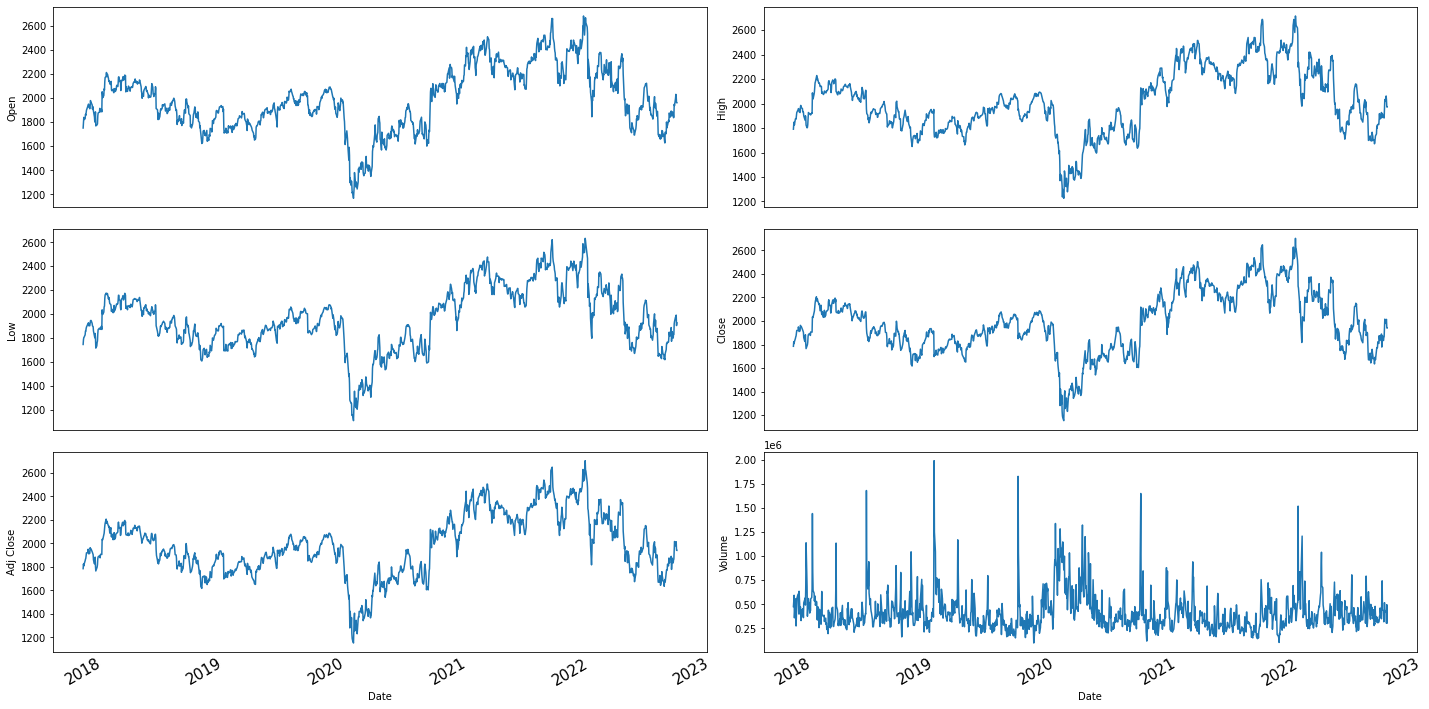

In [12]:
symbol ='BKNG'
stock_company = 'Booking Holdings Inc'

start_date = '2018-01-01'
end_date =  date.today().strftime("%Y-%m-%d")

df = load(symbol,start_date, end_date)
print(df.head())

print(count(start_date, end_date))

plot(df)

# RNN

In [13]:
sequence_length = 5 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)

h0 = x_train.shape[1] * x_train.shape[2]

In [14]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"


SimpleRNN_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='RNN', lr=lr, loss=loss)

history, y_pred_simplernn, MAE_simplernn, MAPE_simplernn, MDAPE_simplernn, R2_simplernn = evaluate(SimpleRNN_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
31/31 [==============================] - 6s 58ms/step - loss: 0.2586 - val_loss: 0.0349
Epoch 2/50
31/31 [==============================] - 1s 35ms/step - loss: 0.0417 - val_loss: 0.0182
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0277 - val_loss: 0.0138
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0189 - val_loss: 0.0106
Epoch 5/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0146 - val_loss: 0.0091
Epoch 6/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0116 - val_loss: 0.0080
Epoch 7/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0101 - val_loss: 0.0072
Epoch 8/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0090 - val_loss: 0.0063
Epoch 9/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 10/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 11/

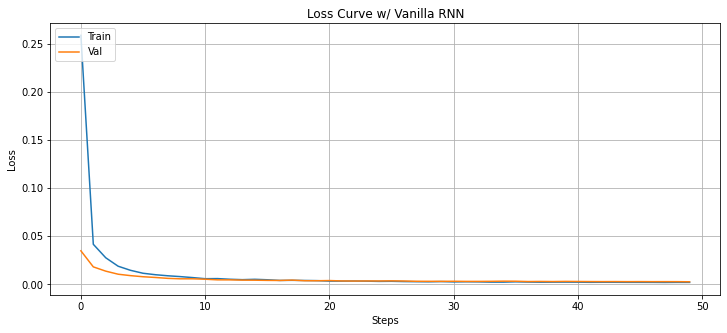

In [15]:
loss_plot(history, epochs=epoch, rnn_type ="Vanilla RNN")


In [16]:
print(MAE_simplernn, MAPE_simplernn, MDAPE_simplernn, R2_simplernn)


61.51891196646342 2.9801362901130526 2.3562463140763548 0.8951874147437973


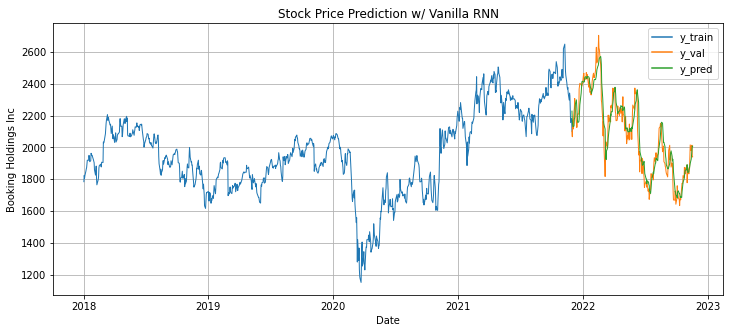

In [17]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_simplernn, stock_company, display_start_date = start_date, rnn_type ="Vanilla RNN")


# LSTM

In [18]:
sequence_length = 5 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test = preprocess(df, seq_len = sequence_length)
h0 = x_train.shape[1] * x_train.shape[2]

In [19]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"
LSTM_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='LSTM',lr=lr, loss=loss)
history, y_pred_LSTM, MAE_LSTM, MAPE_LSTM, MDAPE_LSTM, R2_LSTM= evaluate(LSTM_model, x_train, y_train, x_test, y_test, scaler_pred, epoch=epoch, batch_size=batch_size)


Epoch 1/50
31/31 [==============================] - 9s 42ms/step - loss: 0.1165 - val_loss: 0.0150
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 8/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 11/50
31

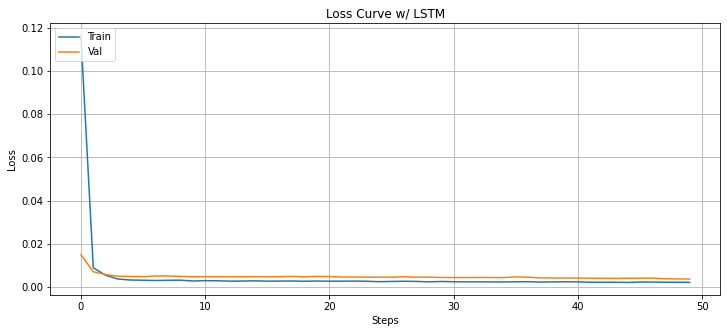

In [20]:
loss_plot(history, epochs=epoch,  rnn_type ="LSTM")


In [21]:
print(MAE_LSTM, MAPE_LSTM, MDAPE_LSTM, R2_LSTM)


74.84602914205412 3.6057318507266825 2.872631636150668 0.8606880265795178


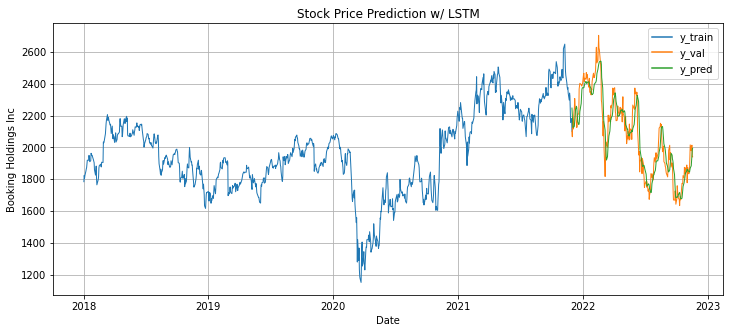

In [22]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_LSTM, stock_company, display_start_date = start_date) #  "2019-01-01" )


# GRU

In [23]:
sequence_length = 5 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)

h0 = x_train.shape[1] * x_train.shape[2]


In [24]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"

GRU_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]),  rnn_type='GRU',lr=lr, loss=loss)
history, y_pred_GRU,  MAE_GRU, MAPE_GRU, MDAPE_GRU, R2_GRU = evaluate(GRU_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
31/31 [==============================] - 5s 40ms/step - loss: 0.0721 - val_loss: 0.0115
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 6/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 8/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 9/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 10/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 11/50
31/31 

In [25]:
print(MAE_GRU, MAPE_GRU, MDAPE_GRU, R2_GRU)


49.576025986089945 2.406421425585504 1.9470462954687013 0.9308900792670757


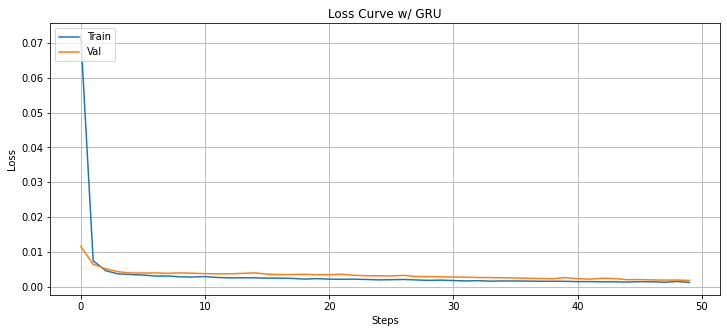

In [26]:
loss_plot(history, epochs=epoch, rnn_type ="GRU")


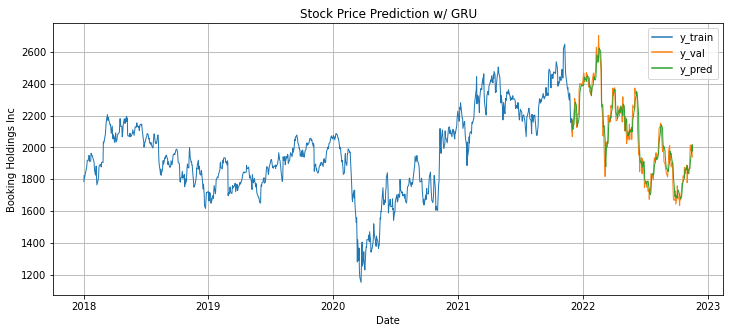

In [27]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_GRU, stock_company, display_start_date = start_date, rnn_type ="GRU")


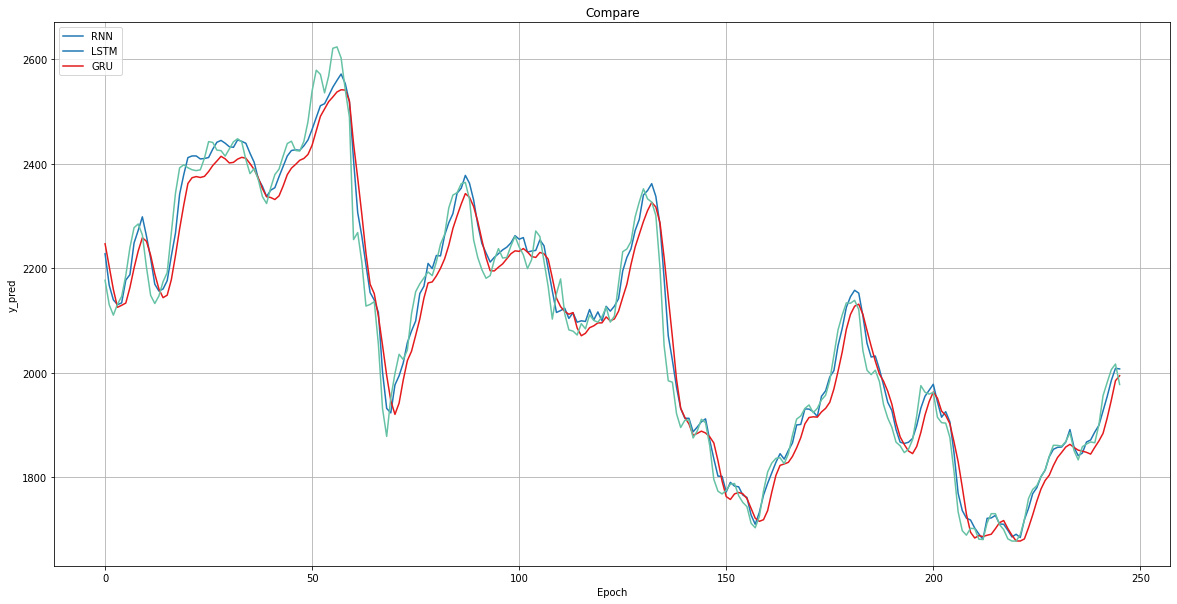

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=y_pred_simplernn)
sns.lineplot(data=y_pred_LSTM, palette="Set1")
sns.lineplot(data=y_pred_GRU,  palette="Set2")
plt.title("Compare")
plt.ylabel("y_pred")
plt.xlabel("Epoch")
plt.legend(["RNN", "LSTM", "GRU"], loc="upper left")
plt.grid()
plt.show()

# Predict Next Day

In [29]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(stock_features)

N = sequence_length

last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = LSTM_model.predict(np.array(X_test_new)) #try best model
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

now_price = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
delta = np.round(100 - (now_price * 100)/predicted_price, 2)
print(end_date)
print('predicted price: ', predicted_price)
print('actual price: ', now_price)
print('delta: ', delta, '%')

1/1 [==============================] - 0s 23ms/step
2022-11-21
predicted price:  1986.47
actual price:  1940.28
delta:  2.33 %
